In [1]:
import torch
import scanpy as sc
import os
from os import path
import numpy as np
import seaborn as sns
import time

In [2]:
import sys
import spaseg
from data_processing import scanpy_processing
from data_processing.scanpy_processing import sc_processing

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
font_size = 6
rc={'font.size': font_size, 'axes.labelsize': 2, 'figure.dpi': 400, 'axes.linewidth':0.2,
    'axes.titlesize': 2, 'xtick.labelsize': 2, 'ytick.labelsize': 2, 
    'scatter.marker':'s',
    'lines.linewidth': 0.5,
    'legend.fontsize':2,
    'legend.markerscale': 3, 'legend.frameon': False, 'legend.fontsize':3,
    'legend.loc': 'lower center',
    'legend.markerscale': 0.6, 
    'legend.borderpad': 0,
    'legend.columnspacing': 0.4,
    'legend.labelspacing': 0.2,
    'legend.handletextpad': 0,
    'legend.borderaxespad': 0.2,
#     'legend.handleheight': 0.6,
#     'legend.handlelength': 0.6,
   }

centimeter = 1/2.54  # centimeter in inches

sns.set(style='ticks',rc=rc) #talk, ticks, paper
sns.set_context("paper")
# sns.palplot(sns.color_palette(flatui))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False # negative minus sign

sc.set_figure_params(facecolor="white", figsize=(3*centimeter, 3*centimeter), dpi=400, dpi_save=400, fontsize=6, )

In [4]:
from spaseg import spaseg

scanpy==1.8.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.3 scipy==1.6.2 pandas==1.3.2 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.7


## Data preprocessing

In [6]:
# for single SRT section data as input, here we use DLPFC 151673 as a demostration
in_file_path = "./data/DLPFC"
sample_id = "151673"
multi_slice = False

in_file_path = os.path.join(in_file_path, "{}.h5ad".format(sample_id))
adata = sc.read_h5ad(in_file_path)

# prepare the input data list for data processing function
adata_list = [adata]
sample_id_list = [sample_id]

/home/guoxiangyu/.conda/envs/SpaSEG_back/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
# For 10X Visium data, we only eliminate genes 
adata_list = sc_processing(adata_list=adata_list,
              sample_id_list=sample_id_list,
              multi_slice=multi_slice,
              st_platform="Visium",
              drop_cell_ratio=0.05,
              min_cells=5,
              compons=15)

----------- Start processing input adata: ------------ 

Filtering adata according to the min_gene and min_cell threshold 


Start to filter the data for sample 151673
the number of spots after filtering min_genes: 3639.
filtered out 15527 genes that are detected in less than 5 cells

----------- Start single-slice adata data processing -----------

AnnData object with n_obs × n_vars = 3639 × 18011
    obs: 'in_tissue', 'array_row', 'array_col', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'
normalizing counts per cell
    finished (0:00

/home/guoxiangyu/.conda/envs/SpaSEG_back/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


## Running SpaSEG model

In [8]:
# weights for segmentation loss and edge strength loss 
alpha=0.4; beta=0.7

torch.cuda.empty_cache()
barcode_index="index"

# initilize SpaSEG model parameters
spaseg_model = spaseg.SpaSEG(adata=adata_list,
                             use_gpu=True,
                             device="cuda:0",
                             input_dim=15,
                             nChannel=15,
                             output_dim=15,
                             sim_weight=alpha,
                             con_weight=beta,
                             min_label=7
                            )

# prepare image-like tensor data for SpaSEG model input
input_mxt, H, W = spaseg_model._prepare_data()

# SpaSEG traning
cluster_label, embedding = spaseg_model._train(input_mxt)



Put the data and model into GPU


/home/guoxiangyu/.conda/envs/SpaSEG_back/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
 22%|███████████████▏                                                     | 461/2100 [00:02<00:08, 190.32it/s]

nLabels 7 reached minLabels 7.


 22%|███████████████▏                                                     | 461/2100 [00:02<00:08, 188.07it/s]


## Result visualization

In [9]:
n_batch = len(sample_id_list)

# Add SpaSEG segmentation label for each spot/bin in SRT data
spaseg_model._add_seg_label(cluster_label, n_batch, H, W, barcode_index="index")

# If ground truth label provided, the ARI and NMI metrics could be calculated
spaseg_model._cal_metrics(ground_truth_index="celltype")

nmi= 0.6738183870681312      ari= 0.553867266307457


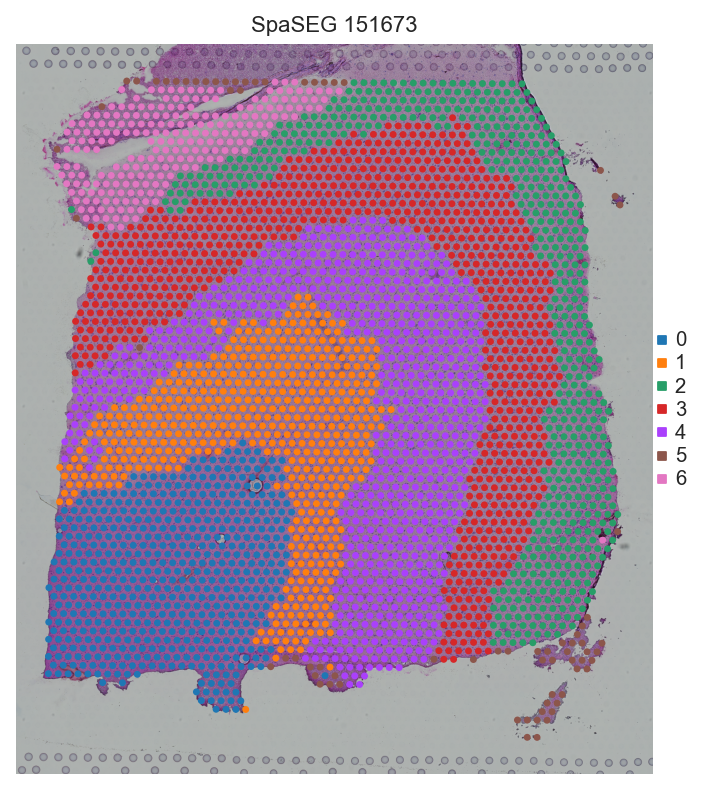

In [11]:
for adata in adata_list:
    sc.pl.spatial(adata, color="SpaSEG_clusters", title="SpaSEG 151673", 
                  frameon=False)